# Class Activation Mapping In PyTorch
Have you ever wondered just how a neural network model like ResNet decides on its decision to determine that an image is a cat or a flower in the field? Class Activation Mappings (CAM) can provide some insight into this process by overlaying a heatmap over the original image to show us where our model thought most strongly that this cat was indeed a cat.

This script will demonstrate how to use a pretrained model, in PyTorch,

To make predictions. Specifically, we will be using VGG16 with a cat image.

References used to make this script:

PyTorch pretrained models doc:

    http://pytorch.org/docs/master/torchvision/models.html

PyTorch image transforms example:

    http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Example code:

    http://blog.outcome.io/pytorch-quick-start-classifying-an-image/

Firstly, we’re going to need a picture of a cat. And thankfully, here’s one I took earlier of a rather suspicious cat that is wondering why the strange man is back in his house again.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import skimage.transform
from PIL import Image
from matplotlib.pyplot import imshow

from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk

import io
import requests

In [3]:
# ImageNet class-index-label
import json

# on cloud
# LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

# at local disk
LABELS_URL = "./imagenet_class_index.json"

# {"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], ...}

idx2label = []
cls2label = {}
# load imagenet class-index
with open(LABELS_URL, "r") as read_file:
    class_indices = json.load(read_file)
    # convert index or class name to label
    idx2label = [class_indices[str(k)][1] for k in range(len(class_indices))]
    cls2label = {class_indices[str(k)][0]: class_indices[str(k)][1] for k in range(len(class_indices))}

In [4]:
# input image
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

# IMG_URL = 'https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492__340.jpg'
# IMG_URL = 'https://cdn.pixabay.com/photo/2018/03/26/20/49/tiger-3264048__340.jpg'
# IMG_URL = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSyOX2T4HLkL_PUaMgKoo6q_NTk0thueXbRN3OAI-2fRyRz4E0iEg'

In [5]:
response = requests.get(IMG_URL)
image = Image.open(io.BytesIO(response.content))
np.array(image).shape

(216, 380, 3)

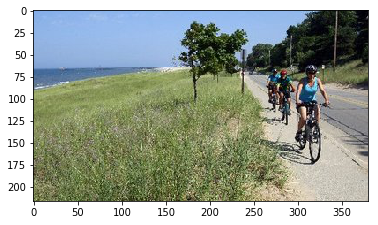

In [6]:
imshow(image)

Next, we’re going to set up some torchvision transforms to scale the image to the 224x224 required for ResNet and also to normalize it to the ImageNet mean/std.

Now that we have an img, we need to preprocess it. We need to:

- Resize the image to its minimal size, required by Resnet.
- Convert it to a PyTorch Tensor.
- Normalize it, as noted in the PyTorch pretrained models doc, with mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

We can do all this preprocessing using a transform pipeline.

In [7]:
# Imagenet mean/std
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet
min_img_size = 224  # The min size, as noted in the PyTorch pretrained models doc, is 224 px.
preprocess = transforms.Compose([
   transforms.Resize((min_img_size, min_img_size)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [8]:
img_tensor = preprocess(image)
print(img_tensor.shape)

torch.Size([3, 224, 224])


In [9]:
# PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
# Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis.
img_var = img_tensor.unsqueeze(0) # Insert the new axis at index 0 i.e. in front of the other axes/dims. 

# send it to gpu and track the graph
img_var = img_var.cuda()
img_var.requires_grad_();

/home/hzh/MachineLearning/equinor/tgs/env_s3i/lib/python3.6/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU0 Quadro K5100M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Having converted our image into a PyTorch variable, we need a model to generate a prediction. Let’s use ResNet18, put it in evaluation mode, and stick it on the GPU using the CUDA libraries.

In [10]:
model = models.resnet18(pretrained=True)
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

This next bit of code is swiped from Jeremy Howard’s fast.ai course. It basically allows you to easily attach a hook to any model (or any part of a model - here we’re going to grab the final convnet layer in ResNet18) which will save the activation features as an instance variable.

In [11]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, inp, outp): self.features = ((outp.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [12]:
final_layer = model._modules.get('layer4')

activated_features = SaveFeatures(final_layer)

Having set that up, we run the image through our model and get the prediction. We then run that through a softmax layer to turn that prediction into a series of probabilities for each of the 1000 classes in ImageNet.

In [13]:
prediction = model(img_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

/home/hzh/MachineLearning/equinor/tgs/env_s3i/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Using topk(), we can see that our model is 78% confident that this picture is class 283. Looking that up in the ImageNet classes, that gives us…’persian cat’. I would say that’s not a bad guess!

In [14]:
probs, indices = topk(pred_probabilities,1)
probs, indices

(tensor([0.4374], device='cuda:0'), tensor([671], device='cuda:0'))

Having made the guess, let’s see where the neural network was focussing its attention. The getCAM() method here takes the activated features of the convnet, the weights of the fully-connected layer (on the side of the average pooling), and the class index we want to investigate (283/‘persian cat’ in our case). We index into the fully-connected layer to get the weights for that class and calculate the dot product with our features from the image.

(this code is based on the paper that introduced CAM)

In [15]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img


In [16]:
weight, bias = tuple(model._modules.get('fc').parameters())
weight_softmax = weight.cpu().data.numpy()
print(weight_softmax.shape)

(1000, 512)


In [17]:
top_index = 0

# convert to cpu
prob = probs[top_index].item() * 100
class_idx = indices[top_index].item()

# get CAM
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

In [18]:
#
prob, class_idx, idx2label[class_idx]

(43.742769956588745, 671, 'mountain_bike')

Now we can see our heatmap and overlay it onto Casper. It doesn’t make him look any happier, but we can see exactly where the model made its mind up about him.

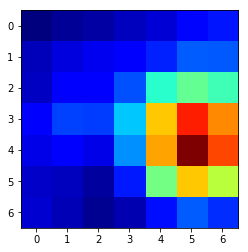

In [19]:
imshow(overlay, cmap='jet')

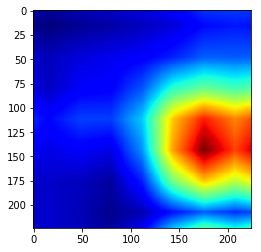

In [20]:
imshow(skimage.transform.resize(overlay, img_tensor.shape[1:3]), cmap='jet');

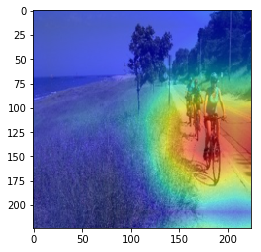

In [21]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay, img_tensor.shape[1:3]), alpha=0.5, cmap='jet');

But wait, there’s a bit more - we can also look at the model’s second choice for Casper.

In [22]:
probs, indices = topk(pred_probabilities,2)
probs, indices

(tensor([0.4374, 0.1310], device='cuda:0'),
 tensor([671, 970], device='cuda:0'))

In [23]:
top_index = 1

# convert to cpu
prob = probs[top_index].item() * 100
class_idx = indices[top_index].item()

# get CAM
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

In [24]:
#
prob, class_idx, idx2label[class_idx]

(13.1039097905159, 970, 'alp')

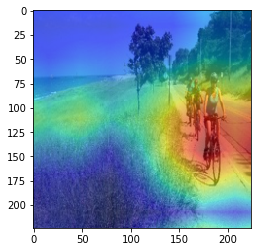

In [25]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay, img_tensor.shape[1:3]), alpha=0.5, cmap='jet');

Although the heatmap is similar, the network is focussing a touch more on his fluffy coat to suggest he might be class 332 - an Angora rabbit. And well, he is a Turkish Angora cat after all…